<a href="https://colab.research.google.com/github/apadros01/Neural_Networks/blob/main/CNN_facial_point_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Aquest notebook té 25GB

# Facial Point Detection using Convolutional Neural Networks
Author: Àlex Padrós Zamora

Github: https://github.com/apadros01

LinkedIn: https://www.linkedin.com/in/alexpadroszamora/

The following 3 cells are necessary for performing the operations with GPU computation.

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

In [4]:
gpu()

<tf.Tensor: shape=(), dtype=float32, numpy=403.0265>

The following 3 cells are the ones that download the data. It's just a copy-paste of what was given in the statement.

In [5]:
# downloading data

%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
!wget https://www.dropbox.com/s/svrvpus93131m98/test.csv
!wget https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv

--2022-02-22 09:50:04--  https://www.dropbox.com/s/svrvpus93131m98/test.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/svrvpus93131m98/test.csv [following]
--2022-02-22 09:50:04--  https://www.dropbox.com/s/raw/svrvpus93131m98/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb1135dc8bc9b0402227ae50a7d.dl.dropboxusercontent.com/cd/0/inline/BgPhuaVupf4X4yn9AnnPTj3kYSyCrh4s1J1ffvniwxFGihPZ4-XKif5AgacGtkj1hUil_wGzqp4PXm2B3xYByPZuz2tAGCMCeJKWBRn9yqTDY5weFOph5NztqFzty0FQCNkqdd_8RknjFaUSLoUrIWYB/file# [following]
--2022-02-22 09:50:05--  https://ucb1135dc8bc9b0402227ae50a7d.dl.dropboxusercontent.com/cd/0/inline/BgPhuaVupf4X4yn9AnnPTj3kYSyCrh4s1J1ffvniwxFGihPZ4-XKif5AgacGtkj1hUil_wGzqp4PXm2B3xYByPZuz2tAGCMCeJK

In [6]:
# loading data

FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

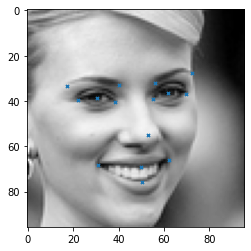

In [7]:
# loading data and checking it

X, y = load()
plot_sample(X[12],y[12])

# Model


The main trick will be the usage of data augmentation.

The *add_brightness()* function is used to increase the brightness of images of the x_train. Parameters a and b allow us to perform some experiments, and they must be set in a way that increase the values of x_train. We use the numpy.minimum(1,...) function because we have scaled the pixel values to [0, 1].

The *add_darkness* function is used in the opposite way, it is used to darken the images. The parameters a and b must be set in a way that reduce the values of x_train. Since we don't want to get a negative value, we use the numpy.maximum(0,...) function. 

In [8]:
def add_brightness(x,a,b):
  nou = np.minimum(1,a*x+b)
  return nou

def add_darkness(x,a,b):
  nou=np.maximum(0,a*x+b)
  return nou

from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

Related to the convolutional part, we add some 2D convolutional layers, and then a Dropout of 20% of the neurons.

In the fully-connected part, we add two dense layers with dimensionality of the output space equal to 300.
For both parts, the activation function will be relu.

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Conv2D, Lambda
from keras.models import Model
import numpy as np


# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3),activation='relu', padding="same"),     
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),

        layers.Dense(300,activation='relu'),
        layers.Dense(300,activation='relu'),
        layers.Dense(output_shape, activation="linear")
        
    ]
)


With this function, we create the dataset depending on the parameters a,b,c,d and the random_state number:

In [10]:
def dataset(random_state,a,b,c,d):
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=random_state)
  x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5,random_state=random_state)
# Make sure images have shape (96, 96, 1) - Keras requirement!
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)
  x_valid = np.expand_dims(x_valid, -1)
  x_nou=add_brightness(x_train,a,b)
  x_nou_2=add_darkness(x_train,c,d)
  x_gran = np.vstack((x_train,x_nou,x_nou_2))
  y_gran = np.vstack((y_train,y_train,y_train))
  return x_gran,y_gran,x_valid,y_valid


The *train()* function performs the model training.  As a new trick, we have changed the learning value (by default, it is 0.01). We have changed it to 0.001. We set the number of epochs to 80.

The *prediction()* function gives us the mean pixel error.

In [11]:
def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))
def train(x,y,batch_size=128,epochs=80,learning_rate=0.001):
  optimizer = keras.optimizers.Adam(lr=0.01)
  model.compile(loss=root_mean_squared_error, optimizer=optimizer)
  K.set_value(model.optimizer.learning_rate, learning_rate)
  model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

def prediction(x,y):
  y_new = model.predict(x)
  return rmse_pixel(y, y_new)

We perform an experiment with some different values for the random state number.

In [12]:
rndm_st= [12,20,36,37,38,39,40,41,42,43,44]
llista=[]
for value in rndm_st:
  x_gran,y_gran,x_valid,y_valid = dataset(value,1.5,0.4,-0.98,0.98)
  # Predefined parameters
  input_shape = (96, 96, 1)
  output_shape = 30
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
          layers.Conv2D(64, kernel_size=(3, 3),activation='relu', padding="same"),     
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Flatten(),
          layers.Dropout(0.2),

          layers.Dense(300,activation='relu'),
          layers.Dense(300,activation='relu'),
          layers.Dense(output_shape, activation="linear")

      ]
  )
  train(x_gran,y_gran)
  llista.append(prediction(x_valid,y_valid))

print('The mean value for all mean pixel errors is: '+str(np.mean(llista)))
print('The minimum has been: '+str(np.min(llista)))
print('The maximum has been: '+str(np.max(llista)))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/80
32/32 [==============================] - 6s 85ms/step - loss: 0.1204 - val_loss: 0.0742
Epoch 2/80
32/32 [==============================] - 2s 58ms/step - loss: 0.0690 - val_loss: 0.0684
Epoch 3/80
32/32 [==============================] - 2s 58ms/step - loss: 0.0667 - val_loss: 0.0696
Epoch 4/80
32/32 [==============================] - 2s 60ms/step - loss: 0.0657 - val_loss: 0.0691
Epoch 5/80
32/32 [==============================] - 2s 60ms/step - loss: 0.0638 - val_loss: 0.0628
Epoch 6/80
32/32 [==============================] - 2s 60ms/step - loss: 0.0594 - val_loss: 0.0580
Epoch 7/80
32/32 [==============================] - 2s 58ms/step - loss: 0.0543 - val_loss: 0.0544
Epoch 8/80
32/32 [==============================] - 2s 61ms/step - loss: 0.0509 - val_loss: 0.0495
Epoch 9/80
32/32 [==============================] - 2s 60ms/step - loss: 0.0480 - val_loss: 0.0476
Epoch 10/80
32/32 [==============================] - 2s 58ms/step - loss: 0.0455 - val_loss: 0.0445
Epoch 11/

As we can see, last time I compiled the code, I obtained: 
- A mean value for all mean pixel errors of $1.3950094$
- The best result that I got in this iteration was a mean pixel error of $1.3129808$
- The worst result that I got in this iteration was a mean pixel error of $1.4630226$
